### **[Transferencia de Aprendizaje y Fine Tuning](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=es-419)** ###

Para mejorar nuestro modelo, es posible hacer uso del aprendizaje de transferencia, basándo nuestro modelo en una red previamente entrenada.

Un modelo preentrenado es una red guardada que se entrenó previamente en un gran conjunto de datos, generalmente en una tarea de clasificación de imágenes a gran escala. Puede usar el modelo preentrenado tal como está o usar el aprendizaje de transferencia para personalizar este modelo para una tarea determinada.

La intuición detrás del aprendizaje de transferencia para la clasificación de imágenes es que si un modelo se entrena en un conjunto de datos lo suficientemente grande y general, este modelo servirá efectivamente como un modelo genérico del mundo visual. A continuación, puede aprovechar estos mapas de características aprendidos sin tener que empezar de cero entrenando un modelo grande en un conjunto de datos grande.

Para más detalle sobre el proceso de [Transferencia de Aprendizaje](https://www.tensorflow.org/guide/keras/transfer_learning?hl=es-419)...

Vamos a trabajar con tres Conjuntos de Datos:

1. **Conjunto de Entrenamiento (Training Set)**:

* Propósito: Se utiliza para entrenar el modelo. Durante el entrenamiento, el modelo ajusta sus parámetros basándose en los datos del conjunto de entrenamiento.
* Tamaño: Por lo general, representa la mayoría de los datos disponibles (por ejemplo, el 80% del total).
* Uso: El modelo ve y aprende de estos datos para mejorar su capacidad de hacer predicciones.

2. **Conjunto de Validación (Validation Set)**:

* Propósito: Se utiliza para ajustar los hiperparámetros y prevenir el sobreajuste (overfitting). Los hiperparámetros son configuraciones que no se ajustan durante el entrenamiento, pero afectan el rendimiento del modelo.
* Tamaño: Generalmente, es un porcentaje más pequeño del conjunto total de datos (por ejemplo, el 10-20% restante).
* Uso: Después de cada época (iteración completa a través del conjunto de entrenamiento), el modelo se evalúa en el conjunto de validación. Esto ayuda a ajustar los hiperparámetros para mejorar el rendimiento general del modelo.

3. **Conjunto de Prueba (Test Set) (Opcional)**:

* Propósito: Se utiliza para evaluar el rendimiento final del modelo después de que se ha entrenado y ajustado en el conjunto de entrenamiento y validación.
* Tamaño: Similar al conjunto de validación, un porcentaje pequeño del conjunto total de datos.
* Uso: El modelo no ve estos datos durante el entrenamiento ni el ajuste de hiperparámetros. Se utiliza al final para obtener una estimación no sesgada del rendimiento del modelo en datos nuevos.

Tareas:

1. Examinar y comprender los datos.
2. Cree una tubería de entrada, en este caso usando Keras ImageDataGenerator
3. Componer el modelo
    * Carga en el modelo base preentrenado (y pesos preentrenados)
    * Apila las capas de clasificación en la parte superior
4. Entrenar al modelo
5. Evaluar modelo

**Modulos:**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

**Descarga de Datos:**

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True) # Descarga y Descomprime
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

Utilizamos la función **tf.keras.utils.image_dataset_from_directory** para realizar la Carga y Preprocesado de los Datasets de Entrenamiento y Validación. Parámetros:
* train_dir: Directorio que contiene las imágenes a cargar en el Dataset.
* shuffle: Modificar o no al azar la ordenación de las imágenes.
* batch_size: Tamaño de los Batch para la transacción.
* image_size: Tamaño de las imágenes deseado.

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

class_names = train_dataset.class_names

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
print(class_names)
print(train_dataset)

for element in train_dataset:
    print(element)
    break

Mostramos las primeras nueve imágenes y etiquetas del conjunto de entrenamiento:

In [ ]:
plt.figure(figsize=(5, 5))                   # Tamaño en el que se muestran las imágenes
for images, labels in train_dataset.take(1): # La función ds.take(n) devuelve un dataset con los primeros n elementos del dataset original (en este caso, el primer elemente sería un Batch con 32 imágenes)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)        # Genera una cuadrícula de 3x3 y coloca la imange en la posición correspondiente según el índice del bucle
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Como el conjunto de datos original no contiene un conjunto de prueba, creará uno. Para hacerlo, determine cuántos lotes de datos están disponibles en el conjunto de validación mediante tf.data.experimental.cardinality y luego mueva el 20 % de ellos a un conjunto de prueba.

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset) # Obtenemos el número de Batches del Dataset de Validación
test_dataset = validation_dataset.take(val_batches // 5)           # Creamos el Dataset de Pruebas (Test) tomando el 20% (//5 división entera) de los Batches del Dataset de Validación
validation_dataset = validation_dataset.skip(val_batches // 5)     # Quitamos los Batches utilizados en el nuevo Dataset del Dataset de Validación
val_batches2 = tf.data.experimental.cardinality(validation_dataset)
print(val_batches)
print(val_batches2)

tf.Tensor(32, shape=(), dtype=int64)
tf.Tensor(26, shape=(), dtype=int64)


In [ ]:
print('Número de batches de entrenamiento: %d' % tf.data.experimental.cardinality(train_dataset))
print('Número de batches de validación: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Número de batches de prueba: %d' % tf.data.experimental.cardinality(test_dataset))

**Configurar el conjunto de datos para el rendimiento:**

Utilizamos la captación previa almacenada en búfer para cargar imágenes desde el disco sin que la E/S se convierta en un bloqueo.

Las GPU y TPU pueden reducir radicalmente el tiempo necesario para ejecutar un solo paso de entrenamiento. Lograr el máximo rendimiento requiere una canalización de entrada eficiente que entregue datos para el siguiente paso antes de que finalice el paso actual. La API tf.data ayuda a **[construir canalizaciones](https://www.tensorflow.org/guide/data_performance?hl=es-419)** de entrada flexibles y eficientes.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

**Usar aumento de datos:**

Cuando no se tiene un conjunto de datos de imágenes grande, es una buena práctica introducir artificialmente diversidad de muestras mediante la aplicación de transformaciones aleatorias pero realistas a las imágenes de entrenamiento, como la rotación y el volteo horizontal. Esto ayuda a exponer el modelo a diferentes aspectos de los datos de entrenamiento y reduce el sobreajuste. [Más...](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=es-419)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

**Cambiar la escala de los valores de píxeles:**

En un momento, descargará tf.keras.applications.MobileNetV2 para usarlo como su modelo base. Este modelo espera valores de píxel en [-1, 1] , pero en este punto, los valores de píxel en sus imágenes están en [0, 255] . Para volver a escalarlos, utilice el método de preprocesamiento incluido con el modelo.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# También se puede hacer con la siguiente instrucción
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

**Creación del modelo base a partir de las convnets preentrenadas:**

Creamos el modelo base a partir del modelo MobileNet V2 desarrollado en Google. Éste se entrenó previamente en el conjunto de datos de ImageNet, un gran conjunto de datos que consta de 1,4 millones de imágenes y 1000 clases. ImageNet es un conjunto de datos de entrenamiento de investigación con una amplia variedad de categorías como jackfruit y syringe . Esta base de conocimientos nos ayudará a clasificar perros y gatos a partir de nuestro conjunto de datos específico.

Primero, elegimos qué capa de MobileNet V2 utilizará para la extracción de características. La última capa de clasificación ("arriba", ya que la mayoría de los diagramas de modelos de aprendizaje automático van de abajo hacia arriba) no es muy útil. En su lugar, seguimos la práctica común de depender de la última capa antes de la operación de aplanado. Esta capa se llama "Capa Cuello de Botella". Las características de la capa cuello de botella conservan más generalidad en comparación con la capa final/superior.

Creamos una instancia de un modelo MobileNet V2 precargado con pesos entrenados en ImageNet. Al especificar el argumento include_top=False, cargamos una red que no incluye las capas de clasificación en la parte superior, lo que es ideal para la extracción de características.

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Este extractor de características convierte cada imagen de 160x160x3 en un bloque de características de 5x5x1280 . Vemos lo que le hace a un lote de imágenes de ejemplo:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.summary()

### **Extracción de características** ###

En este paso, congelamos la base convolucional creada en el paso anterior y la utilizamos como extractor de características. Además, agregamos un clasificador encima y entrenamos el clasificador de nivel superior.

**Congelar la base convolucional:**

Es importante congelar la base convolucional antes de compilar y entrenar el modelo. Congelar (estableciendo layer.trainable = False) evita que los pesos en una capa determinada se actualicen durante el entrenamiento. MobileNet V2 tiene muchas capas, por lo que establecer la bandera trainable de todo el modelo en False las congelará todas.

In [ ]:
base_model.trainable = False

**Nota importante sobre las capas de BatchNormalization**
    
Muchos modelos contienen capas tf.keras.layers.BatchNormalization. Esta capa es un caso especial y se deben tomar precauciones en el contexto del ajuste fino.

Cuando establecemos layer.trainable = False, la capa BatchNormalization se ejecuta en modo de inferencia y no actualiza sus estadísticas de media y varianza.

Cuando descongelamos un modelo que contiene capas de BatchNormalization para realizar un ajuste fino, se deben mantener las capas de BatchNormalization en modo de inferencia pasando training = False al llamar al modelo base. De lo contrario, las actualizaciones aplicadas a los pesos no entrenables destruirán lo aprendido por el modelo.

[Para obtener más detalles...](https://www.tensorflow.org/guide/keras/transfer_learning?hl=es-419)

**Agregar un encabezado de clasificación:**

Para generar predicciones a partir del bloque de entidades, promediamos las ubicaciones espaciales de 5x5 utilizando una capa tf.keras.layers.GlobalAveragePooling2D para convertir las entidades en un único vector de 1280 elementos por imagen.

In [42]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Aplicamos una capa tf.keras.layers.Dense para convertir estas características en una sola predicción por imagen. No necesitamos una función de activación aquí porque esta predicción se tratará como un logit o un valor de predicción sin procesar. Los números positivos predicen la clase 1, los números negativos predicen la clase 0.

In [43]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Creamos un modelo encadenando las capas de aumento de datos, reescalado, base_model y extractor de características mediante la API funcional de Keras . Usamos training=False ya que nuestro modelo contiene capas BatchNormalization.

In [44]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

**Compilar el modelo:**

Compilamos el modelo antes de entrenarlo. Dado que hay dos clases, usamos la pérdida tf.keras.losses.BinaryCrossentropy con from_logits=True, ya que el modelo proporciona una salida lineal.

In [45]:
base_learning_rate = 0.0001 # Evitamos que la modificación realizada en los pesos y sesgos durante el proceso de entrenamiento sea muy elevada
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

Los 2,5 millones de parámetros en MobileNet están congelados, pero hay 1,2 mil parámetros entrenables en la capa densa. Se dividen entre dos objetos tf.Variable, pesos y sesgos.

**Entrenar al Modelo:**

In [48]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 45s 985ms/step - loss: 0.5843 - accuracy: 0.6535


In [49]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.58
initial accuracy: 0.65


In [50]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 121s 1s/step - loss: 0.5500 - accuracy: 0.6975 - val_loss: 0.4177 - val_accuracy: 0.7389
Epoch 2/10
63/63 [==============================] - 81s 1s/step - loss: 0.4394 - accuracy: 0.7650 - val_loss: 0.3125 - val_accuracy: 0.8453
Epoch 3/10
63/63 [==============================] - 80s 1s/step - loss: 0.3498 - accuracy: 0.8335 - val_loss: 0.2571 - val_accuracy: 0.8775
Epoch 4/10
63/63 [==============================] - 76s 1s/step - loss: 0.3037 - accuracy: 0.8670 - val_loss: 0.2121 - val_accuracy: 0.9097
Epoch 5/10
63/63 [==============================] - 76s 1s/step - loss: 0.2757 - accuracy: 0.8815 - val_loss: 0.1869 - val_accuracy: 0.9233
Epoch 6/10
63/63 [==============================] - 75s 1s/step - loss: 0.2377 - accuracy: 0.8960 - val_loss: 0.1688 - val_accuracy: 0.9307
Epoch 7/10
63/63 [==============================] - 76s 1s/step - loss: 0.2372 - accuracy: 0.8965 - val_loss: 0.1469 - val_accuracy: 0.9468
Epoch 8/10
63/63 [=

**Curvas de aprendizaje:**

Mostramos las curvas de aprendizaje de la precisión/pérdida de capacitación y validación cuando se usa el modelo base de MobileNetV2 como un extractor de características fijas.

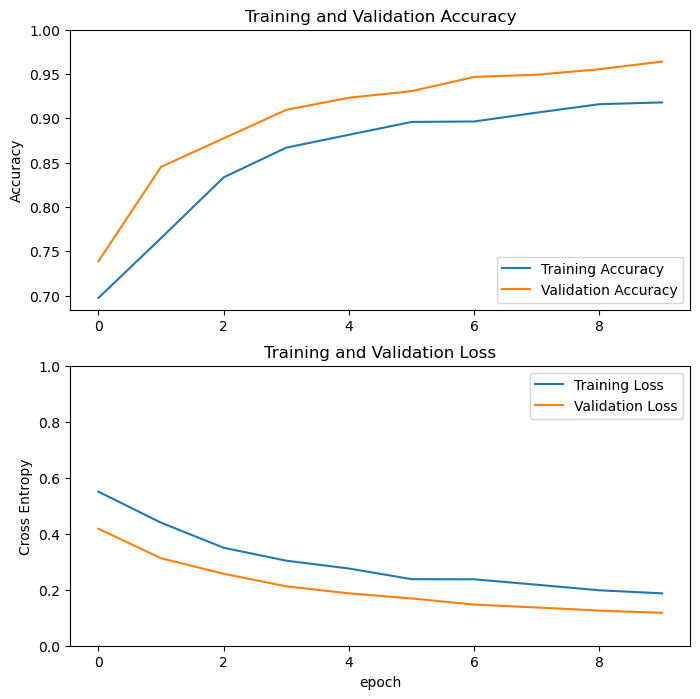

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine Tuning:**

Hasta el momento, sólo hemos entrenado algunas capas sobre un modelo base de MobileNetV2. Los pesos de la red preentrenada no se actualizaron durante el entrenamiento.

Podemos aumentar aún más el rendimiento al entrenar (o "afinar") los pesos de las capas superiores del modelo preentrenado junto con el entrenamiento del clasificador que hemos añadido por encima. El proceso de entrenamiento obligará a ajustar los pesos de los mapas de características genéricas a las características asociadas específicamente con el conjunto de datos.

**WARNING**

No intentar sin haber entrenado el clasificador de nivel superior con el modelo preentrenado establecido en no entrenable previamente. Si agregamos un clasificador inicializado aleatoriamente encima de un modelo previamente entrenado e intentamos entrenar todas las capas juntas, la magnitud de las actualizaciones de gradiente sería demasiado grande (debido a los pesos aleatorios del clasificador) y el modelo previamente entrenado olvidaría lo que había aprendido.

Hay que intentar ajustar una pequeña cantidad de capas superiores en lugar de todo el modelo de MobileNet. En la mayoría de las redes convolucionales, cuanto más arriba está una capa, más especializada es. Las primeras capas aprenden características muy simples y genéricas que se generalizan a casi todos los tipos de imágenes. A medida que avanza, las funciones son cada vez más específicas para el conjunto de datos en el que se entrenó el modelo. El objetivo del ajuste fino es adaptar estas características especializadas para que funcionen con el nuevo conjunto de datos, en lugar de sobrescribir el aprendizaje genérico.

**Descongelar las capas superiores del modelo:**

1. Descongelar el base_model.
2. Configurar las capas inferiores para que no se puedan entrenar.
3. Volver a compilar el modelo (necesario para que estos cambios surtan efecto).
4. Reanudar el entrenamiento.

In [52]:
base_model.trainable = True # Descongelamos el Modelo Base

In [53]:
# Visualizamos el número de capas de modelo base
print("Número de capas de modelo base: ", len(base_model.layers))

Número de capas de modelo base:  154


In [54]:
# Aplicamos Fine Tuning a partir de la capa 100
fine_tune_at = 100

# Congelamos las capas inferiores que no deseamos reentrenar
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
# Compilamos el modelo de nuevo
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

In [ ]:
Hemos pasado de 1.280 parámetros entrenables (80s por época) a 1.8 millones (100s por época).

In [56]:
# Reentrenamos el modelo según la nueva configuración
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 138s 2s/step - loss: 0.1478 - accuracy: 0.9435 - val_loss: 0.0581 - val_accuracy: 0.9827
Epoch 11/20
63/63 [==============================] - 95s 2s/step - loss: 0.1115 - accuracy: 0.9565 - val_loss: 0.0590 - val_accuracy: 0.9814
Epoch 12/20
63/63 [==============================] - 96s 2s/step - loss: 0.0943 - accuracy: 0.9630 - val_loss: 0.0474 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 96s 2s/step - loss: 0.0928 - accuracy: 0.9615 - val_loss: 0.0642 - val_accuracy: 0.9790
Epoch 14/20
63/63 [==============================] - 94s 1s/step - loss: 0.0814 - accuracy: 0.9705 - val_loss: 0.0428 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 94s 1s/step - loss: 0.0753 - accuracy: 0.9665 - val_loss: 0.0337 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 98s 2s/step - loss: 0.0703 - accuracy: 0.9720 - val_loss: 0.0366 - val_accuracy: 0.9827
Epoch 17/20


Mostramos las curvas de aprendizaje de la precisión/pérdida de entrenamiento y validación tras ajustar las últimas capas del modelo base de MobileNetV2 y entrenar el clasificador superior. La pérdida de validación es mucho mayor que la pérdida de entrenamiento, por lo que es posible que se sobreajuste.

También es posible que se sobreajuste, ya que el nuevo conjunto de entrenamiento es relativamente pequeño y similar a los conjuntos de datos originales de MobileNetV2.

Después de un ajuste fino, el modelo alcanza casi el 98 % de precisión en el conjunto de validación.

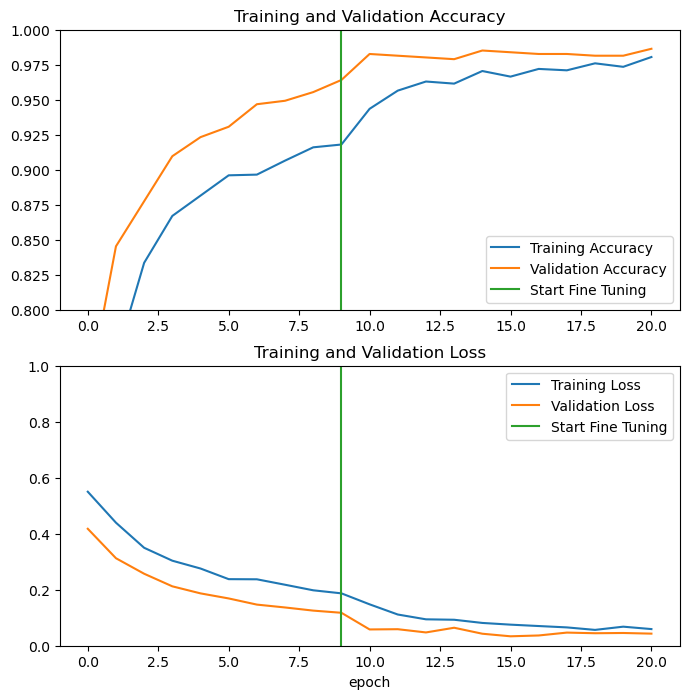

In [58]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Evaluación y Predicción:**

Finalmente,vamos ae verificar el rendimiento del modelo en nuevos datos utilizandoeln conjunto de pruebsa.

In [59]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 7s 875ms/step - loss: 0.0511 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


Ya está todo listo para usar este modelo para predecir una imagen.

Predictions:
 [1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0]
Labels:
 [1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0]


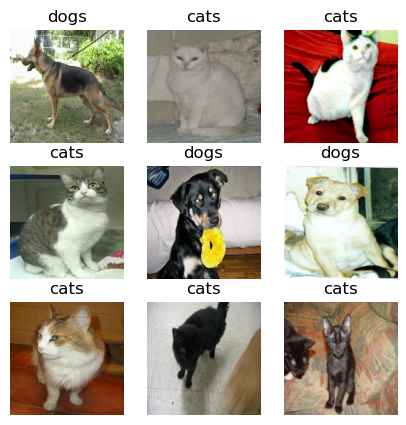

In [60]:
# Recuperamos un batch de imágenes del conjunto de Pruebas
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Aplicamos un Sigmoide porque nuestro modelo devuelve logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(5, 5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

**Guardar Modelo:**

Una vez disponemos de un modelo que funciona muy bien, queremos guardarlo para utilizarlo posteriormente y predecir con él.

In [61]:
model.save('dogs_vs_cats.h5')

**Recuperar Modelo:**

In [62]:
new_model = tf.keras.models.load_model('dogs_vs_cats.h5')

In [64]:
loss, accuracy = new_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 16s 1s/step - loss: 0.0205 - accuracy: 0.9948
Test accuracy : 0.9947916865348816
